# Fakes | Real News Detection

Natural Language Processing - Python | MBD OCT 2018 | Stavros Tsentemeidis | Ashley O'Mahony  
*IE School of Human Sciences and Technology*  

***

# Introduction


The purpose of this assignment done in pairs, is to develop a machine learning pipeline, in order to be able to detect whether a news article is fake or real.  

The problem is characterized as **Text Binary Classification**.

## Libraries

This project uses these libraries for data manipulation, processing and modelling.

In [1]:
# # Connecting the Colab Notebook to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Loading Libraries
import pandas as pd #Data Manipulation
pd.set_option('display.max_columns', 500)

import numpy as np #Data Manipulation
import datetime
import re  
import nltk 
import pickle 
import xgboost
import string
import gensim
import itertools

import matplotlib.pyplot as plt #Plotting
import matplotlib.ticker as ticker #Plotting
import seaborn as sns #Plotting
import sklearn.feature_extraction.text

sns.set(style='white')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 12

from sklearn import preprocessing #Preprocessing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures #Preprocessing

from scipy.stats import skew, boxcox_normmax #Preprocessing
from scipy.special import boxcox1p #Preprocessing

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm #Modeling
from sklearn.datasets import load_files  
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix #Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, cross_validate, train_test_split # CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFE #Feature Selection
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier #Modeling

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from keras import layers, models, optimizers, initializers, regularizers, constraints
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten, Convolution1D, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

nltk.download('stopwords') 
nltk.download('wordnet')


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Ashley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Ashley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Loading

We read the Training and Test files from the Gists we created on GitHub. This method facilitates the reproducability of the notebook.

In [3]:
train_news = pd.read_csv("https://gist.githubusercontent.com/ashomah/d0b6880eada8030ecac60ea3c7d80504/raw/8ea6418aafb568eab05d92961a8e1a89fee280fc/fake_or_real_news_training.csv",
                         sep = ',',                     #(?!\s)(?!\d)(?!\")(?!\”)(?!\’)(?!\)(?!\])',   Regex temptative
                         engine = "python",
                        error_bad_lines = False)
train_news.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [4]:
test_news = pd.read_csv("https://gist.githubusercontent.com/ashomah/82ea265ff0e89b96d54d9d790351668c/raw/d9af3de87ddabf1faec76cdca84fe7e71db21392/fake_or_real_news_test.csv")
test_news.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


The Training and Test files now loaded, we can check their structure and quality. The function **df_desc** describes the structure of the datesets, and the function **data_qualityCheck** checks the overall data quality.  

In [5]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                         'Date': df.dtypes == 'datetime64[ns]',
                        })
    return desc

In [76]:
# Check the quality of our dataframes
def data_qualityCheck():
    
    print("Checking data quality for TRAIN")
    print('')
    train_news.isnull().sum()
    train_news.info()
        
    print("Check finished.")
    print('')
    print("Checking data quality for TEST")
    print('')
    
    test_news.isnull().sum()
    test_news.info()
    print("Check finished.")

In [77]:
# Run the below function call to see the quality check results
data_qualityCheck()

Checking data quality for TRAIN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 7 columns):
ID           3999 non-null int64
title        3999 non-null object
text         3999 non-null object
label        3999 non-null int64
X1           0 non-null object
X2           0 non-null object
full_text    3999 non-null object
dtypes: int64(2), object(5)
memory usage: 218.8+ KB
Check finished.

Checking data quality for TEST

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 4 columns):
ID           2321 non-null int64
title        2321 non-null object
text         2321 non-null object
full_text    2321 non-null object
dtypes: int64(1), object(3)
memory usage: 72.6+ KB
Check finished.


In [8]:
df_desc(train_news)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
label,False,True,False,0,False,object
X1,False,True,False,3966,False,object
X2,False,True,False,3997,False,object


In [9]:
df_desc(test_news)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object


We notice here that the Train set has some values in the columns `X1` and `X2`, when they should be only filled with `NA`s. After investigation, we realized that some commas are present in some articles, and the function `read_csv` consider them as delimiters.  

We tried using Regex to filter every occurence which would cause this error, but the function doesn't perform exactly the same way when Regex is used in the `delimiter` parameter. Thus, after several trials, we decided to correct the Train set manually, thanks to the small number of rows with issues.  

In [10]:
# Fixing bad lines in Train
train_news.loc[train_news['X1'].notnull() & train_news['X2'].isnull(), 'title'] = train_news.loc[train_news['X1'].notnull(), 'title'] + ',' + train_news.loc[train_news['X1'].notnull(), 'text']
train_news.loc[train_news['X1'].notnull() & train_news['X2'].isnull(), 'text'] = train_news.loc[train_news['X1'].notnull(), 'label']
train_news.loc[train_news['X1'].notnull() & train_news['X2'].isnull(), 'label'] = train_news.loc[train_news['X1'].notnull(), 'X1']
train_news.loc[train_news['X1'].notnull() & train_news['X2'].isnull(), 'X1'] = np.nan

train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'title'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'title'] + ',' + train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'text'] + ', ' + train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'label']
train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'text'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'X1']
train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'label'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[0], 'X2']

train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'title'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'title'] + ',' + train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'text']
train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'text'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'label'] + ',' + train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'X1']
train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'label'] = train_news.loc[train_news['title'] == train_news.loc[train_news['X2'].notnull(), 'title'].iloc[1], 'X2']

train_news.loc[train_news['X2'].notnull(), 'X1'] = np.nan
train_news.loc[train_news['X2'].notnull(), 'X2'] = np.nan

After this data manipulation, the datasets are cleaned and ready to use.  

In [11]:
# Run the below function call to see the quality check results
data_qualityCheck()

Checking data quality for TRAIN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
ID       3999 non-null int64
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       0 non-null object
X2       0 non-null object
dtypes: int64(1), object(5)
memory usage: 187.5+ KB
check finished.

Checking data quality for TEST

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 3 columns):
ID       2321 non-null int64
title    2321 non-null object
text     2321 non-null object
dtypes: int64(1), object(2)
memory usage: 54.5+ KB
check finished.


In [12]:
df_desc(train_news)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
label,False,True,False,0,False,object
X1,False,True,False,3999,False,object
X2,False,True,False,3999,False,object


In [13]:
df_desc(test_news)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object


# Data Preparation

We merge the `title` and `text` column into the **`full text`** column, as adding information from the article title that might be helpful for our analysis.  

In [14]:
train_news['full_text'] = train_news['title'].str.cat(train_news['text'],sep=" ")
test_news['full_text'] = test_news['title'].str.cat(test_news['text'],sep=" ")

In [15]:
train_news.head()

,ID,title,text,label,X1,X2,full_text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,Kerry to go to Paris in gesture of sympathy U....
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,The Battle of New York: Why This Primary Matte...


We encode the `label` variable to **0 (REAL)** and **1 (FAKE)**.

In [16]:
# Encoding labels to 0 (REAL) and 1 (FAKE)  
train_news['label'] = np.where(train_news['label']=='FAKE', 1, 0)

We then pre-process the `full text` in order to avoid common errors and noise on the text. The transformations are:  

* Remove **special characters**  
* Remove **single characters**  
* Remove single characters **from the start**  
* Substitute multiple spaces with **single space**  
* Remove **prefixes**  
* Format to **lower case**  
* **Lemmatize**  

In [17]:
train_news_fixed = train_news.copy()

stemmer = WordNetLemmatizer()

for sen in range(0, len(train_news_fixed['full_text'])):  
    # Remove all the special characters
    title = re.sub(r'\W', ' ', str(train_news_fixed.loc[sen,'full_text']))

    # Remove all single characters
    title = re.sub(r'\s+[a-zA-Z]\s+', ' ', title)

    # Remove single characters from the start
    title = re.sub(r'\^[a-zA-Z]\s+', ' ', title) 

    # Substituting multiple spaces with single space
    title = re.sub(r'\s+', ' ', title, flags=re.I)

    # Removing prefixed 'b'
    title = re.sub(r'^b\s+', '', title)

    # Formating to lower case
    title = title.lower()

    # Lemmatization
    title = title.split()

    title = [stemmer.lemmatize(word) for word in title]
    title = ' '.join(title)

    train_news_fixed.loc[sen,'full_text'] = title

In [18]:
train_news['full_text'].head(10)

0    You Can Smell Hillary’s Fear Daniel Greenfield...
1    Watch The Exact Moment Paul Ryan Committed Pol...
2    Kerry to go to Paris in gesture of sympathy U....
3    Bernie supporters on Twitter erupt in anger ag...
4    The Battle of New York: Why This Primary Matte...
5    Tehran, USA   \nI’m not an immigrant, but my g...
6    Girl Horrified At What She Watches Boyfriend D...
7    ‘Britain’s Schindler’ Dies at 106 A Czech stoc...
8    Fact check: Trump and Clinton at the 'commande...
9    Iran reportedly makes new push for uranium con...
Name: full_text, dtype: object

In [19]:
train_news_fixed['full_text'].head(10)

0    you can smell hillary fear daniel greenfield s...
1    watch the exact moment paul ryan committed pol...
2    kerry to go to paris in gesture of sympathy s ...
3    bernie supporter on twitter erupt in anger aga...
4    the battle of new york why this primary matter...
5    tehran usa m not an immigrant but my grandpare...
6    girl horrified at what she watch boyfriend do ...
7    britain schindler dy at 106 czech stockbroker ...
8    fact check trump and clinton at the commander ...
9    iran reportedly make new push for uranium conc...
Name: full_text, dtype: object

In [20]:
test_news_fixed = test_news.copy()

stemmer = WordNetLemmatizer()

for sen in range(0, len(test_news_fixed['full_text'])):  
    # Remove all the special characters
    title = re.sub(r'\W', ' ', str(test_news_fixed.loc[sen,'full_text']))

    # Remove all single characters
    title = re.sub(r'\s+[a-zA-Z]\s+', ' ', title)

    # Remove single characters from the start
    title = re.sub(r'\^[a-zA-Z]\s+', ' ', title) 

    # Substituting multiple spaces with single space
    title = re.sub(r'\s+', ' ', title, flags=re.I)

    # Removing prefixed 'b'
    title = re.sub(r'^b\s+', '', title)

    # Formating to lower case
    title = title.lower()

    # Lemmatization
    title = title.split()

    title = [stemmer.lemmatize(word) for word in title]
    title = ' '.join(title)

    test_news_fixed.loc[sen,'full_text'] = title

In [21]:
test_news['full_text'].tail(10)

2311    Will the Media Reset After the Election or Are...
2312    DOJ COMPLAINT: Comey Under Fire Over Partisan ...
2313    GOP Senator David Perdue Jokes About Praying f...
2314    Radio Derb Is On The Air–Leonardo And Brazil’s...
2315    Assange claims ‘crazed’ Clinton campaign tried...
2316    State Department says it can't find emails fro...
2317    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318    Anti-Trump Protesters Are Tools of the Oligarc...
2319    In Ethiopia, Obama seeks progress on peace, se...
2320    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: full_text, dtype: object

In [22]:
test_news_fixed['full_text'].tail(10)

2311    will the medium reset after the election or ar...
2312    doj complaint comey under fire over partisan w...
2313    gop senator david perdue joke about praying fo...
2314    radio derb is on the air leonardo and brazil m...
2315    assange claim crazed clinton campaign tried to...
2316    state department say it can find email from cl...
2317    the in pb should stand for plutocratic or pent...
2318    anti trump protester are tool of the oligarchy...
2319    in ethiopia obama seek progress on peace secur...
2320    jeb bush is suddenly attacking trump here why ...
Name: full_text, dtype: object

# Train/Validation Split

We split our Train set into **Train** and **Validation** sets using a 90|10 ratio.  

In [23]:
# Split the data (90% Train, 10% Validation)
train_data, valid_data, train_labels, valid_labels = sklearn.model_selection.train_test_split(train_news_fixed['full_text'], train_news_fixed['label'], test_size=0.10, random_state=42)

# Transform into different formats for Machine Learning

### Count Vectorizer

A **Count Vector** is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency of appearance of the term in this document.  

In [24]:
# Create a Count Vectorizer object
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', stop_words='english')
count_vect.fit(train_data)

# Transform the Train and Test sets using Count Vectorizer object
train_text_count =  count_vect.transform(train_data)
valid_text_count  =  count_vect.transform(valid_data)
test_text_count   =  count_vect.transform(test_news_fixed['full_text'])

print('The shape of Train Text Count Vector is ', train_text_count.shape)
print('The shape of Valid Text Count Vector is  ', valid_text_count.shape)
print('The shape of Test Text Count Vector is  ', test_text_count.shape)

The shape of Train Text Count Vector is  (3599, 47427)
The shape of Valid Text Count Vector is   (400, 47427)
The shape of Test Text Count Vector is   (2321, 47427)


### TF-IDF (Term Frequency - Inverse Document Frequency)

The **TF-IDF** score represents the relative importance of a term in the document and in the entire corpus. TF-IDF score consists in two terms:  
* the first term computes the normalized **Term Frequency (TF)**,
* the second term is the **Inverse Document Frequency (IDF)**, computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.  

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)*   

*IDF(t) = log(Total number of documents / Number of documents with term t in it)*

</br>

We performed this transformation at 3 levels:  

1. **Word Level TF-IDF**: matrix representing TF-IDF scores of every term in different documents.  
2. **N-gram Level TF-IDF**: N-grams are the combination of N terms together. This matrix represents the TF-IDF scores of N-grams.  
3. **Character Level TF-IDF**: matrix representing TF-IDF scores of character N-grams in the corpus.  

**Normalization : `L1`, `L2` or `None`, optional (default = `L2`)**

#### Word Level


In [25]:
# Word level TF-IDF
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=25000, stop_words='english')
tfidf_vect.fit(train_data)
train_tfidf =  tfidf_vect.transform(train_data)
valid_tfidf =  tfidf_vect.transform(valid_data)
test_tfidf  =  tfidf_vect.transform(test_news_fixed['full_text'])

print('The shape of Train Text TF-IDF Word Vector is ', train_tfidf.shape)
print('The shape of Valid Text TF-IDF Word Vector is  ', valid_tfidf.shape)
print('The shape of Test Text TF-IDF Word Vector is  ', test_tfidf.shape)

The shape of Train Text TF-IDF Word Vector is  (3599, 25000)
The shape of Valid Text TF-IDF Word Vector is   (400, 25000)
The shape of Test Text TF-IDF Word Vector is   (2321, 25000)


#### N-gram Level

In [26]:
# N-gram level TF-IDF 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=42000, stop_words='english')
tfidf_vect_ngram.fit(train_data)
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data)
valid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_data)
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_news_fixed['full_text'])

print('The shape of Train Text TF-IDF N-gram Vector is ', train_tfidf_ngram.shape)
print('The shape of Valid Text TF-IDF N-gram Vector is ', valid_tfidf_ngram.shape)
print('The shape of Test Text TF-IDF N-gram Vector is ', test_tfidf_ngram.shape)

The shape of Train Text TF-IDF N-gram Vector is  (3599, 42000)
The shape of Valid Text TF-IDF N-gram Vector is  (400, 42000)
The shape of Test Text TF-IDF N-gram Vector is  (2321, 42000)


#### Character Level

In [27]:
# Character level TF-IDF
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,5), max_features=6600)
tfidf_vect_ngram_chars.fit(train_data)
train_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_data) 
valid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_data) 
test_tfidf_ngram_chars  =  tfidf_vect_ngram_chars.transform(test_news_fixed['full_text'])

print('The shape of Train Text TF-IDF N-gram Character Vector is ', train_tfidf_ngram_chars.shape)
print('The shape of Valid Text TF-IDF N-gram Character Vector is  ', valid_tfidf_ngram_chars.shape)
print('The shape of Test Text TF-IDF N-gram Character Vector is  ', test_tfidf_ngram_chars.shape)

The shape of Train Text TF-IDF N-gram Character Vector is  (3599, 6600)
The shape of Valid Text TF-IDF N-gram Character Vector is   (400, 6600)
The shape of Test Text TF-IDF N-gram Character Vector is   (2321, 6600)


## Feature Engineering

Throughout our pre-processing steps, we decided the create new variables out of the text to incorporate them in our models, in order to improve our prediction performance. The new variables can be grouped in two types:  

</br>

Features related to the **Text Structure**  
* **Characters** count
* **Word** count
* **Word density** = characters count / (word count + 1)
* **Punctuation** count
* **Title word** count
* **Upper case** word count

---

Features related to **Meaning and Intention**  
*   **Noun** count  
*   **Verb** count  
*   **Adjective** count  
*   **Adverb** count  
*   **Pronoun** count  

### Creating Text Structure Variables

In [28]:
train_news_fixed['char_count']            = train_news_fixed['full_text'].apply(len)
train_news_fixed['word_count']            = train_news_fixed['full_text'].apply(lambda x: len(x.split()))
train_news_fixed['word_density']          = train_news_fixed['char_count'] / (train_news_fixed['word_count']+1)
train_news_fixed['punctuation_count']     = train_news_fixed['full_text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train_news_fixed['title_word_count']      = train_news_fixed['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_news_fixed['upper_case_word_count'] = train_news_fixed['full_text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


test_news_fixed['char_count']            = test_news_fixed['full_text'].apply(len)
test_news_fixed['word_count']            = test_news_fixed['full_text'].apply(lambda x: len(x.split()))
test_news_fixed['word_density']          = test_news_fixed['char_count'] / (test_news_fixed['word_count']+1)
test_news_fixed['punctuation_count']     = test_news_fixed['full_text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test_news_fixed['title_word_count']      = test_news_fixed['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
test_news_fixed['upper_case_word_count'] = test_news_fixed['full_text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [29]:
df_desc(train_news_fixed)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
label,True,False,False,0,False,int64
X1,False,True,False,3999,False,object
X2,False,True,False,3999,False,object
full_text,False,True,False,0,False,object
char_count,False,False,False,0,True,int64
word_count,False,False,False,0,True,int64
word_density,False,False,False,0,True,float64


In [30]:
df_desc(test_news_fixed)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
full_text,False,True,False,0,False,object
char_count,False,False,False,0,True,int64
word_count,False,False,False,0,True,int64
word_density,False,False,False,0,True,float64
punctuation_count,False,False,False,0,True,int64
title_word_count,False,False,False,0,True,int64
upper_case_word_count,True,False,False,0,False,int64


### Creating Meaning and Intention Variables

In [31]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train_news_fixed['noun_count'] = train_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'noun'))
train_news_fixed['verb_count'] = train_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'verb'))
train_news_fixed['adj_count']  = train_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'adj'))
train_news_fixed['adv_count']  = train_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'adv'))
train_news_fixed['pron_count'] = train_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'pron'))

test_news_fixed['noun_count'] = test_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'noun'))
test_news_fixed['verb_count'] = test_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'verb'))
test_news_fixed['adj_count']  = test_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'adj'))
test_news_fixed['adv_count']  = test_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'adv'))
test_news_fixed['pron_count'] = test_news_fixed['full_text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [32]:
df_desc(train_news_fixed)
#train_news_fixed.head(10)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
label,True,False,False,0,False,int64
X1,False,True,False,3999,False,object
X2,False,True,False,3999,False,object
full_text,False,True,False,0,False,object
char_count,False,False,False,0,True,int64
word_count,False,False,False,0,True,int64
word_density,False,False,False,0,True,float64


In [33]:
df_desc(test_news_fixed)

,Boolean,Categorical,Date,NAs,Numerical,dtype
ID,False,False,False,0,True,int64
title,False,True,False,0,False,object
text,False,True,False,0,False,object
full_text,False,True,False,0,False,object
char_count,False,False,False,0,True,int64
word_count,False,False,False,0,True,int64
word_density,False,False,False,0,True,float64
punctuation_count,False,False,False,0,True,int64
title_word_count,False,False,False,0,True,int64
upper_case_word_count,True,False,False,0,False,int64


# Functions for Training

At this stage, we define four functions that automate the training and validation process, and visualize and summarize the results after training process.  

1.   **Train models**
2.   **Cross-Validation**
3.   **Print Metrics**
4.   **Plot Confusion Matrix**



## Training Function

In [34]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False, param = None):
    if param != None:
        # Type of scoring used to compare parameter combinations
        acc_scorer = make_scorer(accuracy_score)

        # Run the Grid Search
        grid_obj = GridSearchCV(classifier, param, scoring=acc_scorer)

        # Fit the Train dataset on the classifier
        grid_obj = grid_obj.fit(feature_vector_train, label)

        # Fit using the best combination of parameters
        grid_obj = grid_obj.best_estimator_
        grid_obj = grid_obj.fit(feature_vector_train, label)

        # Predict the labels on Validation dataset
        predictions = grid_obj.predict(feature_vector_valid)

        # print ("Accuracy on Validation set:",metrics.accuracy_score(predictions, valid_labels))

        return grid_obj, metrics.accuracy_score(predictions, valid_labels), predictions
    else :
        # Fit the Training dataset on the classifier
        classifier.fit(feature_vector_train, label)

        # Predict the labels on Validation dataset
        predictions = classifier.predict(feature_vector_valid)

        if is_neural_net:
            predictions = predictions.argmax(axis=-1)

    return metrics.accuracy_score(predictions, valid_labels), predictions

## Cross-Validation Function

In [35]:
def cv_acc (model, X_train, y_train, n_splits, seed):
    kfold = model_selection.KFold(n_splits=n_splits, random_state=seed)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))
    print()
    for i in range(len(results)):
        print('Iteration', '{:>2}'.format(i+1), '| Accuracy: {:.2f}'.format(results[i]))

## Print Metrics Function

In [36]:
def print_metrics (y_true, y_pred):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
    print('F1 score: %.3f'% f1_score(y_true, y_pred, average="macro"))
    print('Precision: %.3f'%precision_score(y_true, y_pred, average="macro"))
    print('Recall: %.3f'% recall_score(y_true, y_pred, average="macro"))

## Plot Confusion Matrix Function

In [37]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Modelling

After making sure we have all the necesssary elements for the Machine Learning Pipeline, it is time now to start the modelling part. The algorithms that we are going to test are split in two main categories:  

* **Regular Algorithms**
* **Deep Learning**

Within each algorithm, we test all the possible data formats (which we transformed the text to, in previous steps) and perform an extensive **Grid Search** in order to determine the optimal number of parameters per algorithm per data format.

## Regular Algorithms

### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying based on Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.  

For this study, we use the **Multinomial Naive Bayes**, which implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification.

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


NB, Count Vectors:  0.9025
F1 score: 0.902
Precision: 0.902
Recall: 0.902
10-fold cross validation average accuracy: 0.899

Iteration  1 | Accuracy: 0.90
Iteration  2 | Accuracy: 0.91
Iteration  3 | Accuracy: 0.91
Iteration  4 | Accuracy: 0.88
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.90
Iteration  7 | Accuracy: 0.88
Iteration  8 | Accuracy: 0.91
Iteration  9 | Accuracy: 0.89
Iteration 10 | Accuracy: 0.89



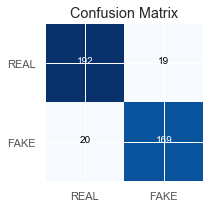

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


NB, WordLevel TF-IDF:  0.9125
F1 score: 0.912
Precision: 0.912
Recall: 0.913
10-fold cross validation average accuracy: 0.907

Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.90
Iteration  4 | Accuracy: 0.88
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.92
Iteration  7 | Accuracy: 0.89
Iteration  8 | Accuracy: 0.91
Iteration  9 | Accuracy: 0.91
Iteration 10 | Accuracy: 0.89



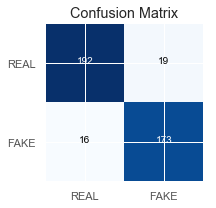

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


NB, N-Gram Vectors:  0.935
F1 score: 0.935
Precision: 0.936
Recall: 0.934
10-fold cross validation average accuracy: 0.927

Iteration  1 | Accuracy: 0.93
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.94
Iteration  4 | Accuracy: 0.91
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.92
Iteration  7 | Accuracy: 0.91
Iteration  8 | Accuracy: 0.93
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.92



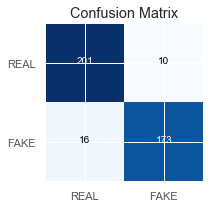

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


NB, CharLevel Vectors:  0.8175
F1 score: 0.817
Precision: 0.830
Recall: 0.823
10-fold cross validation average accuracy: 0.846

Iteration  1 | Accuracy: 0.84
Iteration  2 | Accuracy: 0.89
Iteration  3 | Accuracy: 0.86
Iteration  4 | Accuracy: 0.84
Iteration  5 | Accuracy: 0.86
Iteration  6 | Accuracy: 0.84
Iteration  7 | Accuracy: 0.85
Iteration  8 | Accuracy: 0.83
Iteration  9 | Accuracy: 0.82
Iteration 10 | Accuracy: 0.83


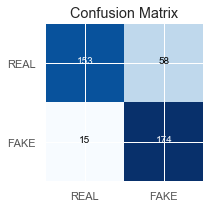

In [38]:
alpha_list = np.linspace(0.006, 0.1, 40)
alpha_list = np.around(alpha_list, decimals=4)
alpha_list
parameter_NB = [{"alpha":alpha_list}]

# Naive Bayes on Count Vectors
best_model, accuracy, predictions  = train_model(naive_bayes.MultinomialNB(), train_text_count, train_labels, valid_text_count, param = parameter_NB)
print ("NB, Count Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_text_count, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Naive Bayes on Word Level TF IDF Vectors
best_model, accuracy, predictions = train_model(naive_bayes.MultinomialNB(), train_tfidf, train_labels, valid_tfidf, param = parameter_NB)
print ("NB, WordLevel TF-IDF: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Naive Bayes on Ngram Level TF IDF Vectors
best_model, accuracy, predictions = train_model(naive_bayes.MultinomialNB(), train_tfidf_ngram, train_labels, valid_tfidf_ngram, param = parameter_NB)
print ("NB, N-Gram Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf_ngram, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Naive Bayes on Character Level TF IDF Vectors
best_model, accuracy, predictions = train_model(naive_bayes.MultinomialNB(), train_tfidf_ngram_chars, train_labels, valid_tfidf_ngram_chars, param = parameter_NB)
print ("NB, CharLevel Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf_ngram_chars, train_labels, 10, 2019)
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# N gram 40000(2,3) = 92.7

With the Naive Bayes algorithm, we obtain a good accuracy of **0.927 in Cross-Validation using the TF-IDF N-gram** dataset.  

In the opposite, the result of the TF-IDF at Character level is really disappointing, with an accuracy of 0.846 only in Cross-Validation.  

### Passive Aggresive Classifier

The passive-aggressive algorithms are a family of algorithms for large-scale learning. They don't require a learning rate, but include a regularization parameter `c`.

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


PAC, Count Vectors:  0.9125
F1 score: 0.912
Precision: 0.912
Recall: 0.914
10-fold cross validation average accuracy: 0.904

Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.91
Iteration  3 | Accuracy: 0.91
Iteration  4 | Accuracy: 0.88
Iteration  5 | Accuracy: 0.92
Iteration  6 | Accuracy: 0.89
Iteration  7 | Accuracy: 0.90
Iteration  8 | Accuracy: 0.89
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.90



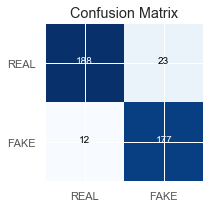

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


PAC, WordLevel TF-IDF:  0.9325
F1 score: 0.932
Precision: 0.932
Recall: 0.933
10-fold cross validation average accuracy: 0.919

Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.90
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.93
Iteration  8 | Accuracy: 0.92
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.91



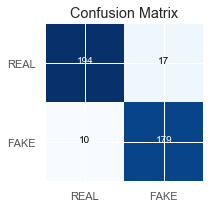

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


PAC, N-Gram Vectors:  0.92
F1 score: 0.920
Precision: 0.920
Recall: 0.921
10-fold cross validation average accuracy: 0.925

Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.92
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.91
Iteration  8 | Accuracy: 0.93
Iteration  9 | Accuracy: 0.91
Iteration 10 | Accuracy: 0.92



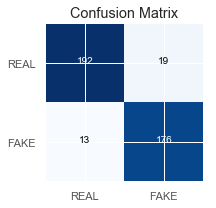

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


NB, CharLevel Vectors:  0.8575
F1 score: 0.857
Precision: 0.867
Recall: 0.862
10-fold cross validation average accuracy: 0.879

Iteration  1 | Accuracy: 0.86
Iteration  2 | Accuracy: 0.90
Iteration  3 | Accuracy: 0.87
Iteration  4 | Accuracy: 0.84
Iteration  5 | Accuracy: 0.89
Iteration  6 | Accuracy: 0.88
Iteration  7 | Accuracy: 0.88
Iteration  8 | Accuracy: 0.88
Iteration  9 | Accuracy: 0.88
Iteration 10 | Accuracy: 0.90



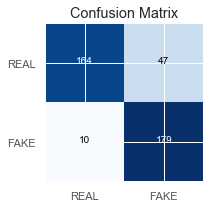

In [82]:
c_list = np.linspace(0.006, 0.1, 40)
c_list = np.around(c_list, decimals=4)
parameter_PAC = [{"C":c_list}]


# PAC on Count Vectors
best_model, accuracy, predictions  = train_model(PassiveAggressiveClassifier(), train_text_count, train_labels, valid_text_count, param = parameter_PAC)
print ("PAC, Count Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_text_count, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# PAC on Word Level TF IDF Vectors
best_model, accuracy, predictions = train_model(PassiveAggressiveClassifier(), train_tfidf, train_labels, valid_tfidf, param = parameter_PAC)
print ("PAC, WordLevel TF-IDF: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# PAC on Ngram Level TF IDF Vectors
best_model_pac, accuracy, predictions = train_model(PassiveAggressiveClassifier(), train_tfidf_ngram, train_labels, valid_tfidf_ngram, param = parameter_PAC)
print ("PAC, N-Gram Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model_pac, train_tfidf_ngram, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# PAC on Character Level TF IDF Vectors
best_model, accuracy, predictions = train_model(PassiveAggressiveClassifier(), train_tfidf_ngram_chars, train_labels, valid_tfidf_ngram_chars, param = parameter_PAC)
print ("NB, CharLevel Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf_ngram_chars, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')


With Passive Aggressive Classifier, the TF-IDF at N-gram level is again better, with a value of **0.927 in Cross-Validation**.  

### Linear Classifier | Logistic Regression

The Logisitic Regression, also known as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier, is a linear classifier providing the probabilities of the possible outcomes.  

For this analysis, we also tested the impact of `L1` and `L2` regularizations on the models.  

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors:  0.9175
F1 score: 0.917
Precision: 0.917
Recall: 0.918
10-fold cross validation average accuracy: 0.918

Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.94
Iteration  4 | Accuracy: 0.90
Iteration  5 | Accuracy: 0.93
Iteration  6 | Accuracy: 0.92
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.91
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.91



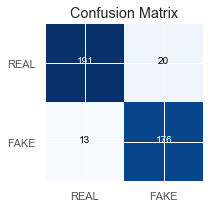

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, WordLevel TF-IDF:  0.9325
F1 score: 0.932
Precision: 0.932
Recall: 0.933
10-fold cross validation average accuracy: 0.930

Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.90
Iteration  5 | Accuracy: 0.95
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.93
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.92



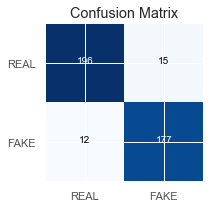

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, N-Gram Vectors:  0.935
F1 score: 0.935
Precision: 0.935
Recall: 0.936
10-fold cross validation average accuracy: 0.924

Iteration  1 | Accuracy: 0.93
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.92
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.92
Iteration  7 | Accuracy: 0.90
Iteration  8 | Accuracy: 0.91
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.92



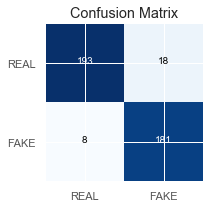

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, CharLevel Vectors:  0.895
F1 score: 0.895
Precision: 0.895
Recall: 0.896
10-fold cross validation average accuracy: 0.909

Iteration  1 | Accuracy: 0.89
Iteration  2 | Accuracy: 0.92
Iteration  3 | Accuracy: 0.90
Iteration  4 | Accuracy: 0.89
Iteration  5 | Accuracy: 0.91
Iteration  6 | Accuracy: 0.89
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.92
Iteration 10 | Accuracy: 0.91



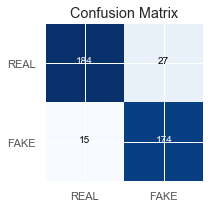

In [40]:
parameters_lr={"C":np.logspace(-3,3,10), "penalty":["l1","l2"]}# l1 lasso l2 ridge

# Linear Classifier on Count Vectors
best_model, accuracy, predictions = train_model(linear_model.LogisticRegression(), train_text_count, train_labels, valid_text_count, param = parameters_lr)
print ("LR, Count Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_text_count, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Linear Classifier on Word Level TF IDF Vectors
best_model, accuracy, predictions = train_model(linear_model.LogisticRegression(), train_tfidf, train_labels, valid_tfidf, param = parameters_lr)
print ("LR, WordLevel TF-IDF: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Linear Classifier on Ngram Level TF IDF Vectors
best_model, accuracy, predictions = train_model(linear_model.LogisticRegression(), train_tfidf_ngram, train_labels, valid_tfidf_ngram, param = parameters_lr)
print ("LR, N-Gram Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf_ngram, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Linear Classifier on Character Level TF IDF Vectors
best_model, accuracy, predictions = train_model(linear_model.LogisticRegression(), train_tfidf_ngram_chars, train_labels, valid_tfidf_ngram_chars, param = parameters_lr)
print ("LR, CharLevel Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(best_model, train_tfidf_ngram_chars, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# Best 25000 with TFIDF Word Level 93
# Best 45000(2,5) with TFIDF N gram Level 92.7

This time again, the TF-IDF at Word level and at N-gram level provide the best results, but favour would go to the **TF-IDF at Word level**, thanks to its accuracy of **0.930 in Cross-Validation**, which beats the one of TF-IDF at N-gram level.  

### Support Vector Machines


Also known as SVM, Support Vector Machines are effective in high dimensional spaces, and quite effective when the number of features if greater than the number of samples.  

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM, Count Vectors:  0.78
F1 score: 0.776
Precision: 0.823
Recall: 0.790
10-fold cross validation average accuracy: 0.777

Iteration  1 | Accuracy: 0.75
Iteration  2 | Accuracy: 0.81
Iteration  3 | Accuracy: 0.80
Iteration  4 | Accuracy: 0.78
Iteration  5 | Accuracy: 0.78
Iteration  6 | Accuracy: 0.81
Iteration  7 | Accuracy: 0.76
Iteration  8 | Accuracy: 0.77
Iteration  9 | Accuracy: 0.76
Iteration 10 | Accuracy: 0.76



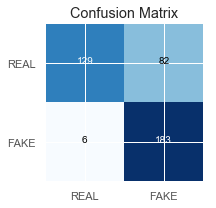


SVM, WordLevel TF-IDF:  0.4725
F1 score: 0.321
Precision: 0.236
Recall: 0.500


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10-fold cross validation average accuracy: 0.477

Iteration  1 | Accuracy: 0.48
Iteration  2 | Accuracy: 0.47
Iteration  3 | Accuracy: 0.47
Iteration  4 | Accuracy: 0.49
Iteration  5 | Accuracy: 0.49
Iteration  6 | Accuracy: 0.44
Iteration  7 | Accuracy: 0.48
Iteration  8 | Accuracy: 0.49
Iteration  9 | Accuracy: 0.48
Iteration 10 | Accuracy: 0.48



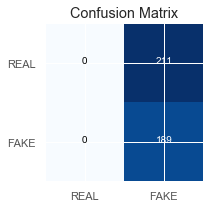


SVM, N-Gram Vectors:  0.4725
F1 score: 0.321
Precision: 0.236
Recall: 0.500
10-fold cross validation average accuracy: 0.477

Iteration  1 | Accuracy: 0.48
Iteration  2 | Accuracy: 0.47
Iteration  3 | Accuracy: 0.47
Iteration  4 | Accuracy: 0.49
Iteration  5 | Accuracy: 0.49
Iteration  6 | Accuracy: 0.44
Iteration  7 | Accuracy: 0.48
Iteration  8 | Accuracy: 0.49
Iteration  9 | Accuracy: 0.48
Iteration 10 | Accuracy: 0.48



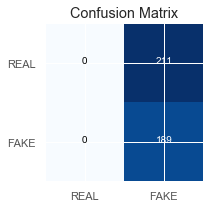


SVM, CharLevel Vectors:  0.4725
F1 score: 0.321
Precision: 0.236
Recall: 0.500
10-fold cross validation average accuracy: 0.477

Iteration  1 | Accuracy: 0.48
Iteration  2 | Accuracy: 0.47
Iteration  3 | Accuracy: 0.47
Iteration  4 | Accuracy: 0.49
Iteration  5 | Accuracy: 0.49
Iteration  6 | Accuracy: 0.44
Iteration  7 | Accuracy: 0.48
Iteration  8 | Accuracy: 0.49
Iteration  9 | Accuracy: 0.48
Iteration 10 | Accuracy: 0.48



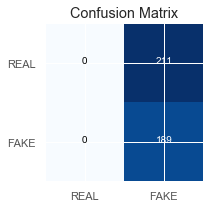

In [41]:
# SVM on Count Vectors
accuracy, predictions = train_model(svm.SVC(), train_text_count, train_labels, valid_text_count)
print ("SVM, Count Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(svm.SVC(), train_text_count, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# SVM on Word Level TF IDF Vectors
accuracy, predictions = train_model(svm.SVC(), train_tfidf, train_labels, valid_tfidf)
print ("SVM, WordLevel TF-IDF: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(svm.SVC(), train_tfidf, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# SVM on Ngram Level TF IDF Vectors
accuracy, predictions = train_model(svm.SVC(), train_tfidf_ngram, train_labels, valid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(svm.SVC(), train_tfidf_ngram, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

# SVM on Character Level TF IDF Vectors
accuracy, predictions = train_model(svm.SVC(), train_tfidf_ngram_chars, train_labels, valid_tfidf_ngram_chars)
print ("SVM, CharLevel Vectors: ", accuracy)
print_metrics(valid_labels, predictions)
cv_acc(svm.SVC(), train_tfidf_ngram_chars, train_labels, 10, 2019)
print('')
plot_confusion_matrix(y_true = valid_labels,
                      y_pred = predictions,
                      normalize    = False,
                      target_names = ['REAL', 'FAKE'],
                      title        = "Confusion Matrix")
print('')

Support Vector Machines don't seem adapted to our dataset, with terrible accuracy scores, not exceeding **0.777 in Cross-Validation**. We also can note that the TF-IDF formats give the same results.  

### Bagging | Random Forest

Random Forest algorithm is an averaging algorithm based on randomized decision-trees. Each tree in the ensemble is built from a sample drawn with replacement from the training set, and when splitting a node, the best split among a random subset of the features is picked.  

For this analysis, we use an extensive Grid Search playing with 6 parameters to find the best model.  

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RF, Count Vectors:  0.8175
F1 score: 0.817
Precision: 0.823
Recall: 0.821
10-fold cross validation average accuracy: 0.787

Iteration  1 | Accuracy: 0.79
Iteration  2 | Accuracy: 0.81
Iteration  3 | Accuracy: 0.83
Iteration  4 | Accuracy: 0.77
Iteration  5 | Accuracy: 0.76
Iteration  6 | Accuracy: 0.82
Iteration  7 | Accuracy: 0.75
Iteration  8 | Accuracy: 0.79
Iteration  9 | Accuracy: 0.75
Iteration 10 | Accuracy: 0.81



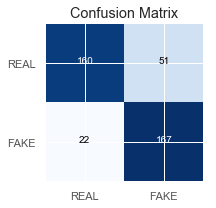

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RF, WordLevel TF-IDF  0.785
F1 score: 0.784
Precision: 0.800
Recall: 0.791
10-fold cross validation average accuracy: 0.797

Iteration  1 | Accuracy: 0.81
Iteration  2 | Accuracy: 0.82
Iteration  3 | Accuracy: 0.81
Iteration  4 | Accuracy: 0.76
Iteration  5 | Accuracy: 0.80
Iteration  6 | Accuracy: 0.79
Iteration  7 | Accuracy: 0.79
Iteration  8 | Accuracy: 0.80
Iteration  9 | Accuracy: 0.80
Iteration 10 | Accuracy: 0.79



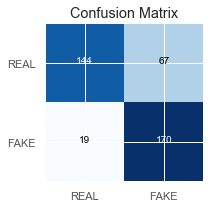

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RF, N-Gram Vectors  0.7725
F1 score: 0.770
Precision: 0.800
Recall: 0.780
10-fold cross validation average accuracy: 0.771

Iteration  1 | Accuracy: 0.76
Iteration  2 | Accuracy: 0.81
Iteration  3 | Accuracy: 0.78
Iteration  4 | Accuracy: 0.78
Iteration  5 | Accuracy: 0.79
Iteration  6 | Accuracy: 0.78
Iteration  7 | Accuracy: 0.76
Iteration  8 | Accuracy: 0.78
Iteration  9 | Accuracy: 0.78
Iteration 10 | Accuracy: 0.70



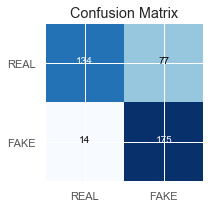

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, CharLevel Vectors  0.8625
F1 score: 0.862
Precision: 0.862
Recall: 0.863
10-fold cross validation average accuracy: 0.809

Iteration  1 | Accuracy: 0.81
Iteration  2 | Accuracy: 0.78
Iteration  3 | Accuracy: 0.86
Iteration  4 | Accuracy: 0.82
Iteration  5 | Accuracy: 0.79
Iteration  6 | Accuracy: 0.82
Iteration  7 | Accuracy: 0.79
Iteration  8 | Accuracy: 0.82
Iteration  9 | Accuracy: 0.82
Iteration 10 | Accuracy: 0.78



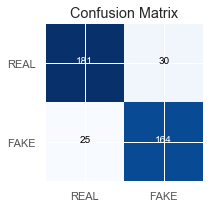

In [73]:
# parameters = {'n_estimators': [4,5,6,7,8,9], 
#               'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [2,3,4,5,6,7,8,9,10], 
#               'min_samples_split': [2,3,4,5,6,7],
#               'min_samples_leaf': [1,2,3,4,5,6,7,8]
#              }

# # RF on Count Vectors
# best_model, accuracy, predictions = train_model(RandomForestClassifier(), train_text_count, train_labels, valid_text_count, param=parameters)
# print ("RF, Count Vectors: ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(best_model, train_text_count, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # RF on Word Level TF IDF Vectors
# best_model, accuracy, predictions = train_model(RandomForestClassifier(), train_tfidf, train_labels, valid_tfidf, param=parameters)
# print ("RF, WordLevel TF-IDF ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(best_model, train_tfidf, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # RF on Ngram Level TF IDF Vectors
# best_model, accuracy, predictions = train_model(RandomForestClassifier(), train_tfidf_ngram, train_labels, valid_tfidf_ngram, param=parameters)
# print ("RF, N-Gram Vectors ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(best_model, train_tfidf_ngram, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # RF on Character Level TF IDF Vectors
# accuracy, predictions = train_model(RandomForestClassifier(), train_tfidf_ngram_chars, train_labels, valid_tfidf_ngram_chars)
# print ("RF, CharLevel Vectors ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(best_model, train_tfidf_ngram_chars, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

With Random Forest, the TF-IDF at Character level gives an accuracy of **0.809 in Cross-Validation**.  

### XGBoost


XGBoost stands for Extreme Gradient Boosting, which is one of the most popular and efficient implementations of the Gradient Boosted Trees algorithm, a supervised learning method that is based on function approximation by optimizing specific loss functions as well as applying several regularization techniques.  

For this analysis, we use an extensive Grid Search playing with 5 parameters to find the best model.  

Xgb, Count Vectors:  0.8975
F1 score: 0.897
Precision: 0.898
Recall: 0.899
10-fold cross validation average accuracy: 0.893

Iteration  1 | Accuracy: 0.87
Iteration  2 | Accuracy: 0.91
Iteration  3 | Accuracy: 0.91
Iteration  4 | Accuracy: 0.86
Iteration  5 | Accuracy: 0.90
Iteration  6 | Accuracy: 0.90
Iteration  7 | Accuracy: 0.89
Iteration  8 | Accuracy: 0.90
Iteration  9 | Accuracy: 0.89
Iteration 10 | Accuracy: 0.90



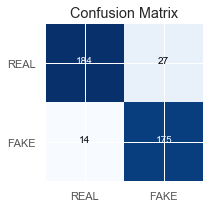


Xgb, WordLevel TF-IDF:  0.8825
F1 score: 0.882
Precision: 0.884
Recall: 0.884
10-fold cross validation average accuracy: 0.896

Iteration  1 | Accuracy: 0.86
Iteration  2 | Accuracy: 0.90
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.87
Iteration  5 | Accuracy: 0.91
Iteration  6 | Accuracy: 0.91
Iteration  7 | Accuracy: 0.87
Iteration  8 | Accuracy: 0.90
Iteration  9 | Accuracy: 0.91
Iteration 10 | Accuracy: 0.90



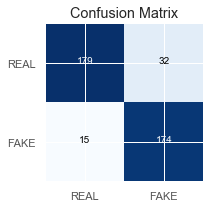


Xgb, Ngram Vectors:  0.8225
F1 score: 0.822
Precision: 0.835
Recall: 0.828
10-fold cross validation average accuracy: 0.837

Iteration  1 | Accuracy: 0.81
Iteration  2 | Accuracy: 0.85
Iteration  3 | Accuracy: 0.89
Iteration  4 | Accuracy: 0.82
Iteration  5 | Accuracy: 0.84
Iteration  6 | Accuracy: 0.86
Iteration  7 | Accuracy: 0.81
Iteration  8 | Accuracy: 0.82
Iteration  9 | Accuracy: 0.84
Iteration 10 | Accuracy: 0.83



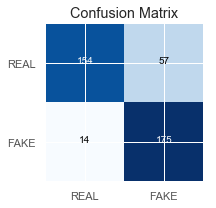


Xgb, CharLevel Vectors:  0.9025
F1 score: 0.902
Precision: 0.903
Recall: 0.904
10-fold cross validation average accuracy: 0.899

Iteration  1 | Accuracy: 0.88
Iteration  2 | Accuracy: 0.89
Iteration  3 | Accuracy: 0.92
Iteration  4 | Accuracy: 0.90
Iteration  5 | Accuracy: 0.90
Iteration  6 | Accuracy: 0.91
Iteration  7 | Accuracy: 0.89
Iteration  8 | Accuracy: 0.91
Iteration  9 | Accuracy: 0.89
Iteration 10 | Accuracy: 0.91



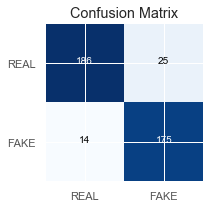

In [75]:
# # parameters_xgb = {
# #         'min_child_weight': [1, 5, 10],
# #         'gamma': [0.5, 1, 1.5, 2, 5],
# #         'subsample': [0.6, 0.8, 1.0],
# #         'colsample_bytree': [0.6, 0.8, 1.0],
# #         'max_depth': [3, 4, 5]
# #         }

# # Extereme Gradient Boosting on Count Vectors
# # best_model,
# accuracy, predictions = train_model(xgboost.XGBClassifier(), train_text_count.tocsc(), train_labels, valid_text_count.tocsc())#, param = parameters_xgb)
# print ("Xgb, Count Vectors: ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(xgboost.XGBClassifier(), train_text_count, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # Extereme Gradient Boosting on Word Level TF IDF Vectors
# # best_model,
# accuracy, predictions = train_model(xgboost.XGBClassifier(), train_tfidf.tocsc(), train_labels, valid_tfidf.tocsc())#, param = parameters_xgb)
# print ("Xgb, WordLevel TF-IDF: ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(xgboost.XGBClassifier(), train_tfidf, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # Extereme Gradient Boosting on Ngram Level TF IDF Vectors
# # best_model,
# accuracy, predictions = train_model(xgboost.XGBClassifier(), train_tfidf_ngram.tocsc(), train_labels, valid_tfidf_ngram.tocsc())#, param = parameters_xgb)
# print ("Xgb, Ngram Vectors: ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(xgboost.XGBClassifier(), train_tfidf_ngram, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

# # Extereme Gradient Boosting on Character Level TF IDF Vectors
# # best_model,
# accuracy, predictions = train_model(xgboost.XGBClassifier(), train_tfidf_ngram_chars.tocsc(), train_labels, valid_tfidf_ngram_chars.tocsc())#, param = parameters_xgb)
# print ("Xgb, CharLevel Vectors: ", accuracy)
# print_metrics(valid_labels, predictions)
# cv_acc(xgboost.XGBClassifier(), train_tfidf_ngram_chars, train_labels, 10, 2019)
# print('')
# plot_confusion_matrix(y_true = valid_labels,
#                       y_pred = predictions,
#                       normalize    = False,
#                       target_names = ['REAL', 'FAKE'],
#                       title        = "Confusion Matrix")
# print('')

With XGBoost, the **TF-IDF at Character level** provides the best result with an Accuracy of **0.899 in Cross-Validation**.  

## Deep Learning

At this point, we decide to try more advanced algorithms included in the **Deep Learning** family.  

We first define a few things:  

1. A function called **train_model_nn** that defines the training process of all the algorithms in an easier and more reproducable way.  
2. Creating **text sequences** for Train and Test sets out of the already cleaned text, which is the receivable format for neural networks.   
3. Filtering the stop words out of the tokens

### Training Pipeline for Neural Network

In [44]:
def train_model_nn(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False, n_epochs=4):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label,  epochs=n_epochs)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_labels), predictions

### Text Sequences

In [45]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_news_fixed['full_text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_news_fixed['full_text'])

maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = train_news_fixed['label']

### Filtering Stop Words

In [46]:
stop_words = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')
clean_train_comments = train_news_fixed.copy()
clean_train_comments['full_text'] = clean_train_comments['full_text'].astype('str') 
clean_train_comments.dtypes
clean_train_comments["tokens"] = clean_train_comments["full_text"].apply(tokenizer.tokenize)
# delete Stop Words
clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
clean_train_comments.head()

,ID,title,text,label,X1,X2,full_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,tokens
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,NaN,NaN,you can smell hillary fear daniel greenfield s...,7165,1264,5.664032,0,4,0,0,0,0,0,0,"[smell, hillary, fear, daniel, greenfield, shi..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,NaN,NaN,watch the exact moment paul ryan committed pol...,2580,448,5.746102,0,13,0,0,0,0,0,0,"[watch, exact, moment, paul, ryan, committed, ..."
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,NaN,NaN,kerry to go to paris in gesture of sympathy s ...,2455,429,5.709302,0,2,0,0,0,0,0,0,"[kerry, go, paris, gesture, sympathy, secretar..."
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,NaN,NaN,bernie supporter on twitter erupt in anger aga...,2571,415,6.180288,0,3,0,0,0,0,0,0,"[bernie, supporter, twitter, erupt, anger, dnc..."
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,NaN,NaN,the battle of new york why this primary matter...,1761,328,5.352584,0,8,0,0,0,0,0,0,"[battle, new, york, primary, matter, primary, ..."


For Neural Networks, we need to format the datasets slightly differently: the tokens are included in a separate column. We created new datasets with this specificity.  

In [47]:
all_training_words = [word for tokens in clean_train_comments["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in clean_train_comments["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

1828773 words total, with a vocabulary size of 49659
Max sentence length is 6034


In [48]:
clean_test_comments = test_news_fixed.copy()
clean_test_comments['full_text'] = clean_test_comments['full_text'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["full_text"].apply(tokenizer.tokenize)
# delete Stop Words
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
clean_test_comments.head()

,ID,title,text,full_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,tokens
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,september new home sale rise back to 1992 leve...,549,91,5.967391,0,7,0,0,0,0,0,0,"[september, new, home, sale, rise, back, 1992,..."
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,why the obamacare doomsday cult can admit it w...,3212,566,5.664903,0,7,0,0,0,0,0,0,"[obamacare, doomsday, cult, admit, wrong, cong..."
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,sander cruz resist pressure after ny loss vow ...,4519,781,5.778772,0,2,0,0,0,0,0,0,"[sander, cruz, resist, pressure, ny, loss, vow..."
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,surviving escaped prisoner likely fatigued and...,6017,1045,5.752390,0,1,0,0,0,0,0,0,"[surviving, escaped, prisoner, likely, fatigue..."
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,clinton and sander neck and neck in california...,3349,570,5.865149,0,3,0,0,0,0,0,0,"[clinton, sander, neck, neck, california, prim..."


In [49]:
all_test_words = [word for tokens in clean_test_comments["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in clean_test_comments["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

1053514 words total, with a vocabulary size of 39783
Max sentence length is 5920


A newer technique that we want to try with the Neural Nets is the **Word Embeddings Technique**.  

We are using here the predefined word embedding vocabulary of [Google](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

</br>

A *word embedding* is a way of representing words and documents using a dense vector. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.  

Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as [Glove](https://nlp.stanford.edu/projects/glove/), [FastText](https://fasttext.cc/), and [Word2Vec](https://code.google.com/archive/p/word2vec/). Any one of them can be downloaded and used as Transfer Learning.  

</br>

There are four essential steps to use pre-trained word embeddings:

1. Loading the **pre-trained word embeddings**.
2. Creating a **tokenizer object**.
3. Transforming text documents to **sequence of tokens** and pad them.
4. Create a **mapping of token** and their respective embeddings.

In [50]:
# # Loading the Google News Vector file from Google Drive
# # TO UPDATE BEFORE EXECUTING
# word2vec_path = "/Users/Ashley/Clouds/Google Drive IE/GoogleNews-vectors-negative300.bin"
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
#     if len(tokens_list)<1:
#         return np.zeros(k)
#     if generate_missing:
#         vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
#     else:
#         vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
#     length = len(vectorized)
#     summed = np.sum(vectorized, axis=0)
#     averaged = np.divide(summed, length)
#     return averaged

# def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
#     embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
#                                                                                 generate_missing=generate_missing))
#     return list(embeddings)

In [51]:
# training_embeddings = get_word2vec_embeddings(word2vec, clean_train_comments, generate_missing=True)
# # test_embeddings = get_word2vec_embeddings(word2vec, clean_test_comments, generate_missing=True)

In [52]:
# EMBEDDING_DIM = 300 # how big is each word vector
# MAX_VOCAB_SIZE = 40000 # how many unique words to use (i.e num rows in embedding vector)
# MAX_SEQUENCE_LENGTH = 200 # max number of words in a comment to use

# tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
# tokenizer.fit_on_texts(clean_train_comments["full_text"].tolist())
# training_sequences = tokenizer.texts_to_sequences(clean_train_comments["full_text"].tolist())

# train_word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(train_word_index))

# train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
# for word,index in train_word_index.items():
#     train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
# print(train_embedding_weights.shape)

Found 49765 unique tokens.
(49766, 300)


We will try different Deep Learning algorithms with this dataset:  

* Convolutional Neural Network with Embeddings
* Recurrent Neural Network with Long Short Term Memory
* Recurrent Neural Network | Gated Recurrent Unit
* Bi-directional Recurrent Neural Network
* Recurrent Convolutional Neural Network
* Shallow Neural Network
* Bi-directional Long Short Term Memory  

### Convolutional Neural Networks | Embeddings

Convolutional Neural Networks consist in one or more convolutional layers, pooling or fully connected, and uses a variation of multilayer perceptrons. Convolutional layers use a convolution operation to the input passing the result to the next layer. This operation allows the network to be deeper with much fewer parameters.  

In [53]:
# def create_cnn():
#     # Add an Input Layer
#     input_layer = layers.Input((200, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(train_word_index) + 1, 300, weights=[train_embedding_weights], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.25)(embedding_layer)

#     # Add the convolutional Layer
#     conv_layer = layers.Convolution1D(128, 4, activation="relu")(embedding_layer)

#     # Add the pooling Layer
#     pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(64, activation="relu")(pooling_layer)
#     output_layer1 = layers.Dropout(0.3, noise_shape=None, seed= 42)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)
#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# classifier = create_cnn()
# #accuracy = train_model_nn(classifier, train_seq_x, train_labels, valid_seq_x, is_neural_net=True)
# classifier.fit(X_t,y, batch_size=100, epochs=10, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3599 samples, validate on 400 samples
Epoch 1/10
3599/3599 [==============================] - 8s 2ms/step - loss: 0.7456 - acc: 0.5235 - val_loss: 0.6664 - val_acc: 0.6025
Epoch 2/10
3599/3599 [==============================] - 6s 2ms/step - loss: 0.6536 - acc: 0.6132 - val_loss: 0.6080 - val_acc: 0.6825
Epoch 3/10
3599/3599 [==============================] - 6s 2ms/step - loss: 0.5662 - acc: 0.7099 - val_loss: 0.5341 - val_acc: 0.7350
Epoch 4/10
3599/3599 [==============================] - 6s 2ms/step - loss: 0.4736 - acc: 0.7774 - val_loss: 0.4453 - val_acc: 0.8000
Epoch 5/10
3599/3599 [==============================] - 6s 2ms/step - loss: 0.3965 - acc: 0.8244 - val_l

For this type of Neural Network, the model seems to learn until the Epoch 9, as the Validation Accuracy starts to vary from Epoch 10 onwards.  

### Recurrent Neural Network | Long Short-Term Memory

Long Short-Term Memory is a specific Recurrent Neural Network architecture that does not use activation function within its recurrent components. The stored values are not modified, and the gradient does not tend to vanish during training. LSTM units are usually implemented in “blocks” with several units. These blocks have three or four “gates” that control information flow drawing on the logistic function.

In [54]:
# def create_rnn_lstm():
#     # Add an Input Layer
#     input_layer = layers.Input((200, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(train_word_index) + 1, 300, weights=[train_embedding_weights], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

#     # Add the LSTM Layer
#     lstm_layer = layers.LSTM(128)(embedding_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(64, activation="relu")(lstm_layer)
#     output_layer1 = layers.Dropout(0.3, noise_shape=None, seed= 42)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# classifier = create_rnn_lstm()
# #accuracy = train_model_nn(classifier, train_seq_x, train_labels, valid_seq_x, is_neural_net=True)
# classifier.fit(X_t,y, batch_size=100, epochs=7, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/7
3599/3599 [==============================] - 18s 5ms/step - loss: 0.6414 - acc: 0.6210 - val_loss: 0.6063 - val_acc: 0.6550
Epoch 2/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.5342 - acc: 0.7349 - val_loss: 0.5109 - val_acc: 0.7525
Epoch 3/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.4779 - acc: 0.7769 - val_loss: 0.4196 - val_acc: 0.8125
Epoch 4/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.4466 - acc: 0.7919 - val_loss: 0.4219 - val_acc: 0.8225
Epoch 5/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.4234 - acc: 0.7991 - val_loss: 0.4414 - val_acc: 0.7975
Epoch 6/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.4169 - acc: 0.8074 - val_loss: 0.3952 - val_acc: 0.8250
Epoch 7/7
3599/3599 [==============================] - 14s 4ms/step - loss: 0.3752 - acc: 0.8397 - val_loss: 0.3922 - val_acc: 0.8300


For this type of Neural Network, the model seems to learn until the Epoch 4, as the Validation Accuracy starts to vary from Epoch 5 onwards.  

### Recurrent Neural Network | Gated Recurrent Unit

Gated Recurrent Unit uses *Update Gate* and *Reset Gate* to solve the vanishing gradient problem of a standard RNN. These are two vectors which decide what information should be passed to the output. They can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

In [55]:
# def create_rnn_gru():
#     # Add an Input Layer
#     input_layer = layers.Input((200, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(train_word_index) + 1, 300, weights=[train_embedding_weights], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.1)(embedding_layer)

#     # Add the GRU Layer
#     lstm_layer = layers.GRU(128)(embedding_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(64, activation="relu")(lstm_layer)
#     output_layer1 = layers.Dropout(0.05, noise_shape=None, seed= 42)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# classifier = create_rnn_gru()
# # accuracy = train_model_nn(classifier, train_seq_x, train_labels, valid_seq_x, is_neural_net=True)
# # print ("RNN-GRU, Word Embeddings",  accuracy)
# classifier.fit(X_t,y, batch_size=100, epochs=6, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/6
3599/3599 [==============================] - 13s 4ms/step - loss: 0.6183 - acc: 0.6593 - val_loss: 0.5645 - val_acc: 0.6975
Epoch 2/6
3599/3599 [==============================] - 12s 3ms/step - loss: 0.4916 - acc: 0.7555 - val_loss: 0.5090 - val_acc: 0.7475
Epoch 3/6
3599/3599 [==============================] - 13s 4ms/step - loss: 0.4392 - acc: 0.7924 - val_loss: 0.4551 - val_acc: 0.7925
Epoch 4/6
3599/3599 [==============================] - 12s 3ms/step - loss: 0.3930 - acc: 0.8283 - val_loss: 0.3847 - val_acc: 0.8350
Epoch 5/6
3599/3599 [==============================] - 11s 3ms/step - loss: 0.3642 - acc: 0.8472 - val_loss: 0.3832 - val_acc: 0.8300
Epoch 6/6
3599/3599 [==============================] - 11s 3ms/step - loss: 0.3356 - acc: 0.8538 - val_loss: 0.3771 - val_acc: 0.8425


For this type of Neural Network, the model seems to learn until the Epoch 4, as the Validation Accuracy starts to vary from Epoch 5 onwards.  

### Bi-directional Recurrent Neural Network

Bi-directional Recurrent Neural Networks are putting two independent RNNs together. The input sequence is fed in normal time order for one network, and in reverse time order for another. The outputs of the two networks are concatenated at each time step.

In [56]:
# def create_bidirectional_rnn():
#     # Add an Input Layer
#     input_layer = layers.Input((200, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(train_word_index) + 1, 300, weights=[train_embedding_weights], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

#     # Add the LSTM Layer
#     lstm_layer = layers.Bidirectional(layers.GRU(128))(embedding_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(564, activation="relu")(lstm_layer)
#     output_layer1 = layers.Dropout(0.05)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# classifier = create_bidirectional_rnn()
# #accuracy = train_model_nn(classifier, train_seq_x, train_labels, valid_seq_x, is_neural_net=True)
# #print ("RNN-Bidirectional, Word Embeddings",  accuracy)
# classifier.fit(X_t,y, batch_size=100, epochs=4, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/4
3599/3599 [==============================] - 21s 6ms/step - loss: 0.6026 - acc: 0.6696 - val_loss: 0.5334 - val_acc: 0.7300
Epoch 2/4
3599/3599 [==============================] - 19s 5ms/step - loss: 0.4538 - acc: 0.7838 - val_loss: 0.4702 - val_acc: 0.8100
Epoch 3/4
3599/3599 [==============================] - 19s 5ms/step - loss: 0.3909 - acc: 0.8233 - val_loss: 0.4251 - val_acc: 0.8000
Epoch 4/4
3599/3599 [==============================] - 19s 5ms/step - loss: 0.3193 - acc: 0.8689 - val_loss: 0.4023 - val_acc: 0.8025


For this type of Neural Network, the model seems to learn until the Epoch 2, as the Validation Accuracy starts to vary from Epoch 3 onwards.  

### Recurrent Convolutional Neural Network

Recurrent Convolutional Neural Network uses bi-directional recurrent structure to replace traditional *window-based* Neural Network to learn representations of texts. It employs then a max-pooling layer that automatically judges which features play key roles in text classification.

In [57]:
# def create_rcnn():
#     # Add an Input Layer
#     input_layer = layers.Input((200, ))

#     # Add the word embedding Layer
#     embedding_layer = layers.Embedding(len(train_word_index) + 1, 300, weights=[train_embedding_weights], trainable=False)(input_layer)
#     embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)
    
#     # Add the recurrent layer
#     rnn_layer = layers.Bidirectional(layers.GRU(64, return_sequences=True))(embedding_layer)
    
#     # Add the convolutional Layer
#     conv_layer = layers.Convolution1D(128, 3, activation="relu")(embedding_layer)

#     # Add the pooling Layer
#     pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

#     # Add the output Layers
#     output_layer1 = layers.Dense(64, activation="relu")(pooling_layer)
#     output_layer1 = layers.Dropout(0.05)(output_layer1)
#     output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

#     # Compile the model
#     model = models.Model(inputs=input_layer, outputs=output_layer2)
#     model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# classifier = create_rcnn()
# #accuracy = train_model_nn(classifier, train_seq_x, train_labels, valid_seq_x, is_neural_net=True)
# #print ("CNN, Word Embeddings",  accuracy)
# classifier.fit(X_t,y, batch_size=100, epochs=9, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/9
3599/3599 [==============================] - 6s 2ms/step - loss: 0.6737 - acc: 0.5754 - val_loss: 0.6134 - val_acc: 0.6250
Epoch 2/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.5321 - acc: 0.7577 - val_loss: 0.4786 - val_acc: 0.7875
Epoch 3/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.4064 - acc: 0.8266 - val_loss: 0.4370 - val_acc: 0.7700
Epoch 4/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.3271 - acc: 0.8647 - val_loss: 0.3416 - val_acc: 0.8450
Epoch 5/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.2499 - acc: 0.9103 - val_loss: 0.3057 - val_acc: 0.8700
Epoch 6/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.2069 - acc: 0.9253 - val_loss: 0.3422 - val_acc: 0.8450
Epoch 7/9
3599/3599 [==============================] - 5s 1ms/step - loss: 0.1631 - acc: 0.9469 - val_loss: 0.2776 - val_acc: 0.8800
Epoch 8/9
3599/3599 [=

For this type of Neural Network, the model seems to learn until the Epoch 5, as the Validation Accuracy starts to vary from Epoch 6 onwards.  

### Shallow Neural Network

Shallow Neural Networks consist in only one or two layers.

In [58]:
# word level tf-idf
tfidf_vect_nn = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=30000, stop_words='english')
tfidf_vect_nn.fit(train_data)

train_tfidf_ngram_nn =  tfidf_vect_nn.transform(train_news_fixed['full_text'])

In [79]:
# ngram level tf-idf 
tfidf_vect_ngram_nn = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,5), max_features=35000, stop_words='english')
tfidf_vect_ngram_nn.fit(train_news_fixed['full_text'])

train_tfidf_ngram_nn =  tfidf_vect_ngram_nn.transform(train_news_fixed['full_text'])
test_tfidf_ngram_nn =  tfidf_vect_ngram_nn.transform(test_news_fixed['full_text'])

In [60]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(128, activation="relu")(input_layer)
    output_layer1 = layers.Dropout(0.73)(hidden_layer)
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(output_layer1)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics =['accuracy'])
    return classifier 

classifier = create_model_architecture(train_tfidf_ngram_nn.shape[1])
#accuracy = train_model_nn(classifier, train_tfidf_ngram, train_labels, valid_tfidf_ngram, is_neural_net=True)
#print ("NN, Ngram Level TF IDF Vectors",  accuracy)
classifier.fit(train_tfidf_ngram_nn,train_news_fixed['label'], batch_size=100, epochs=4, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/4
3599/3599 [==============================] - 4s 1ms/step - loss: 0.6445 - acc: 0.8169 - val_loss: 0.5556 - val_acc: 0.9125
Epoch 2/4
3599/3599 [==============================] - 3s 766us/step - loss: 0.4494 - acc: 0.9478 - val_loss: 0.3778 - val_acc: 0.9300
Epoch 3/4
3599/3599 [==============================] - 3s 786us/step - loss: 0.2799 - acc: 0.9605 - val_loss: 0.2731 - val_acc: 0.9400
Epoch 4/4
3599/3599 [==============================] - 3s 827us/step - loss: 0.1828 - acc: 0.9714 - val_loss: 0.2194 - val_acc: 0.9450


In contrast to the rest of the Neural Networks, this type is actually able to learn and adapt to our dataset. We see that the Validation Accuracy increases at every step.  

### Bi-directional Long Short-Term Memory

Bidirectional Recurrent Neural Networks connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past and future states simultaneously.

In [61]:
# train_news_fixed.head()

,ID,title,text,label,X1,X2,full_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,NaN,NaN,you can smell hillary fear daniel greenfield s...,7165,1264,5.664032,0,4,0,0,0,0,0,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,NaN,NaN,watch the exact moment paul ryan committed pol...,2580,448,5.746102,0,13,0,0,0,0,0,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,NaN,NaN,kerry to go to paris in gesture of sympathy s ...,2455,429,5.709302,0,2,0,0,0,0,0,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,NaN,NaN,bernie supporter on twitter erupt in anger aga...,2571,415,6.180288,0,3,0,0,0,0,0,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,NaN,NaN,the battle of new york why this primary matter...,1761,328,5.352584,0,8,0,0,0,0,0,0


In [62]:
# train_news_fixed.text.apply(lambda x: len(x.split(" "))).mean()

765.4193548387096

In [63]:
# embed_size = 128
# model = Sequential()
# model.add(Embedding(max_features, embed_size))
# model.add(Bidirectional(LSTM(128, return_sequences = True)))
# model.add(GlobalMaxPool1D())
# model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.05))
# model.add(Dense(1, activation="sigmoid"))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_t,y, batch_size=100, epochs=4, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/4
3599/3599 [==============================] - 26s 7ms/step - loss: 0.6535 - acc: 0.6235 - val_loss: 0.4787 - val_acc: 0.7850
Epoch 2/4
3599/3599 [==============================] - 22s 6ms/step - loss: 0.4271 - acc: 0.8233 - val_loss: 0.3599 - val_acc: 0.8525
Epoch 3/4
3599/3599 [==============================] - 22s 6ms/step - loss: 0.2820 - acc: 0.8975 - val_loss: 0.4532 - val_acc: 0.8475
Epoch 4/4
3599/3599 [==============================] - 23s 6ms/step - loss: 0.2298 - acc: 0.9139 - val_loss: 0.3836 - val_acc: 0.8225


For this type of Neural Network, the model seems to learn until the Epoch 2, as the Validation Accuracy starts to vary from Epoch 3 onwards.  

### GOOGLE Embeddings (Experimental Approach)

As a final step, we decided to experiment with a pre-trained model using Google Appendix.  

In [64]:
# test_sequences = tokenizer.texts_to_sequences(clean_test_comments["full_text"].tolist())
# test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [65]:
# from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
# from keras.layers import Conv1D, MaxPooling1D, Embedding
# from keras.layers import LSTM, Bidirectional
# from keras.models import Model
# from keras.callbacks import EarlyStopping


# def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
#     embedding_layer = Embedding(num_words,
#                             embedding_dim,
#                             weights=[embeddings],
#                             input_length=max_sequence_length,
#                             trainable=trainable)

#     sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
#     embedded_sequences = embedding_layer(sequence_input)

#     convs = []
#     filter_sizes = [3,4,5]

#     for filter_size in filter_sizes:
#         l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
#         l_pool = MaxPooling1D(pool_size=3)(l_conv)
#         convs.append(l_pool)

#     l_merge = Concatenate(axis=1)(convs)

#     conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
#     pool = MaxPooling1D(pool_size=5)(conv)

#     if extra_conv==True:
#         x = Dropout(0.05, noise_shape=None, seed= 42)(l_merge)  
#     else:
#         x = Dropout(0.05, noise_shape=None, seed= 42)(pool)
#     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.05, noise_shape=None, seed= 42)(x)

#     preds = Dense(labels_index, activation='sigmoid')(x)

#     model = Model(sequence_input, preds)
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam',
#                   metrics=['acc'])
#     model.summary()
#     return model

In [66]:
# label_names = ["REAL",'FAKE']
# model = ConvNet(train_embedding_weights, 200, len(train_word_index)+1, EMBEDDING_DIM,len(list(label_names)), False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 300)     14929800    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 198, 128)     115328      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 197, 128)     153728      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_5 (

In [67]:
# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
# #hist = model.fit(x_train, y_tr, epochs=10, callbacks=callbacks_list, validation_split=0.2, shuffle=True, batch_size=100)

In [68]:
# train_news_fixed_oh = train_news_fixed.copy()
# # Get one hot encoding of columns B
# one_hot = pd.get_dummies(train_news_fixed_oh['label'])
# # Drop column B as it is now encoded
# train_news_fixed_oh = train_news_fixed_oh.drop('label',axis = 1)
# # Join the encoded df
# train_news_fixed_oh = train_news_fixed_oh.join(one_hot)
# train_news_fixed_oh.head()

,ID,title,text,X1,X2,full_text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,0,1
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",NaN,NaN,you can smell hillary fear daniel greenfield s...,7165,1264,5.664032,0,4,0,0,0,0,0,0,0,1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,NaN,NaN,watch the exact moment paul ryan committed pol...,2580,448,5.746102,0,13,0,0,0,0,0,0,0,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,NaN,NaN,kerry to go to paris in gesture of sympathy s ...,2455,429,5.709302,0,2,0,0,0,0,0,0,1,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",NaN,NaN,bernie supporter on twitter erupt in anger aga...,2571,415,6.180288,0,3,0,0,0,0,0,0,0,1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,NaN,NaN,the battle of new york why this primary matter...,1761,328,5.352584,0,8,0,0,0,0,0,0,1,0


In [69]:
# label_names = [0, 1]
# y_train = train_news_fixed_oh[label_names].values
# # y_train = train_comments[label_names].values
# x_train = train_cnn_data
# y_tr = y_train

In [70]:
# hist = model.fit(x_train, y_tr, epochs=7, callbacks=callbacks_list, validation_split=0.1, batch_size=100)

Train on 3599 samples, validate on 400 samples
Epoch 1/7
3599/3599 [==============================] - 160s 44ms/step - loss: 1.0558 - acc: 0.5479 - val_loss: 0.6822 - val_acc: 0.6375
Epoch 2/7
3599/3599 [==============================] - 21s 6ms/step - loss: 0.6376 - acc: 0.7049 - val_loss: 0.5477 - val_acc: 0.7525
Epoch 3/7
3599/3599 [==============================] - 19s 5ms/step - loss: 0.4545 - acc: 0.7958 - val_loss: 0.4418 - val_acc: 0.7950
Epoch 4/7
3599/3599 [==============================] - 18s 5ms/step - loss: 0.2902 - acc: 0.8846 - val_loss: 0.3439 - val_acc: 0.8350
Epoch 5/7
3599/3599 [==============================] - 18s 5ms/step - loss: 0.1468 - acc: 0.9572 - val_loss: 0.3402 - val_acc: 0.8350
Epoch 6/7
3599/3599 [==============================] - 18s 5ms/step - loss: 0.0644 - acc: 0.9917 - val_loss: 0.4013 - val_acc: 0.8300
Epoch 7/7
3599/3599 [==============================] - 19s 5ms/step - loss: 0.0269 - acc: 0.9978 - val_loss: 0.3922 - val_acc: 0.8500


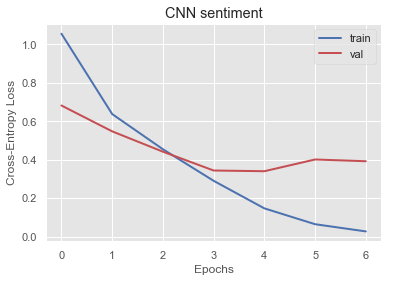

In [71]:
# # Generate plots
# plt.figure()
# plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
# plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
# plt.title('CNN sentiment')
# plt.xlabel('Epochs')
# plt.ylabel('Cross-Entropy Loss')
# plt.legend(loc='upper right')
# plt.show()

With this aditional pre-trained model, the performance isn't great, as we can see that the Validation Accuracy stops with a value of 0.85, and it might also be overfitting due to the really high Cross-Validation Accuracy of 0.9978.  

# Predicting | Creating Submission files

We selected the model **Shallow Neural Network**, as it outperformed every other model we tested. We also selected the dataset format **TF-IDF at N-gram level**, which showed the best results with this neural network.  

In [80]:
y_test_nn = classifier.predict(test_tfidf_ngram_nn)

In [83]:
y_test_pac = best_model_pac.predict(test_tfidf_ngram)

In [89]:
# Create a submission for Neural Network
submission_df_nnet = pd.DataFrame(columns=['ID','target'])
submission_df_nnet['ID'] = test_news_fixed['ID'].values 
submission_df_nnet['target'] = y_test_nn 
submission_df_nnet['target'] = (y_test_nn > 0.5).astype(np.int)
submission_df_nnet.to_csv("nnet_submission.csv", index=False)

In [90]:
# Create a submission for Passive Aggresive
submission_df_pac = pd.DataFrame(columns=['ID','target'])
submission_df_pac['ID'] = test_news_fixed['ID'].values 
submission_df_pac['target'] = y_test_pac 
submission_df_pac.to_csv("pac_submission.csv", index=False)

In [86]:
submission_df_nnet.head(5)

,ID,target
0,10498,1
1,2439,0
2,864,0
3,4128,0
4,662,0


In [87]:
submission_df_pac.head(5)

,ID,target
0,10498,1
1,2439,0
2,864,0
3,4128,0
4,662,0


From this analysis, we can draw a few interesting conclusions:  

* The most important preprocessing step was the cleaning part, and not the lemmatizing and stemming. It improved significantly our model results.  
* Removing *English Stop Words* also boosted our performance.  
* Combining the `title` and the `text` was another benefitial transformation.  
* Modifying the dataset format into a TF-IDF at N-gram level was most of the time outperforming the other formats.  
* In this specific case, the regular algoritms perform better than Neural Networks. We believe that it is due to the limited size of our dataset (4000 rows), which doesn't allow the Neural Networks to learn enough.  